
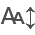

In [ ]:
import numpy as np
import pandas as pd
import itables
import matplotlib as pl

itables.init_notebook_mode()


In [4]:
df = pd.read_csv("data/train.csv")
print(df.shape)
df.head(5)

(1460, 81)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
#############################################################
#### Split df into train, validation, and test ------------------
## 1) Shuffle the df
shuffled_df = df.sample(frac = 1,random_state=1).reset_index(drop=True)

## 2) Set the split ratio 70-10-20 for train-validate-test
split_train_ratio = 0.7
split_validate_ratio = 0.8
df_rows,df_columns = df.shape
split_train_index = int(df_rows * split_train_ratio) 
split_validate_index = int(df_rows * split_validate_ratio)
print(split_train_index,'&',split_validate_index)

## 3) Split the df 
train_df = shuffled_df.iloc[:split_train_index,:]
validate_df = shuffled_df.iloc[split_train_index:split_validate_index,:]
test_df = shuffled_df.iloc[split_validate_index:,:]
print(f'train df: {train_df.shape}')
print(f'validate df: {validate_df.shape}')
print(f'test df: {test_df.shape}')

1021 & 1168
train df: (1021, 81)
validate df: (147, 81)
test df: (292, 81)


In [ ]:
########################################
# -- TRAINING --- #

## Get numerical columns
train_df_num = train_df.select_dtypes(include=['number'])
train_df_num = train_df_num.fillna(train_df_num.mean())
train_df_num.head()
print(f'train df num & replace NaN: {train_df_num.shape}')

train df num & replace NaN: (1021, 38)


In [ ]:
# Set target vector

target_column = 'SalePrice'
target = train_df_num[target_column].to_numpy()

## Reshape target to a (X rows, 1)
target = target.reshape(-1,1)

## Normalize values
target = (target - target.min()) / (target.max() - target.min())
print(f'target size: {target.shape}')
target[0:10]

target size: (1021, 1)


array([[0.27686241],
       [0.20363329],
       [0.12265878],
       [0.06984932],
       [0.15082383],
       [0.40941276],
       [0.35220391],
       [0.1634981 ],
       [0.2254612 ],
       [0.33812139]])

In [ ]:
# Get feature matrix

features_df = train_df_num.drop(target_column, axis=1)
for c in features_df.columns:
    features_df[c] = (features_df[c] - features_df[c].min()) / (features_df[c].max() - features_df[c].min())
features = features_df.to_numpy()
print(f'features size: {features.shape}')
features_df.head(5)

features size: (1021, 37)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
# -- GET VALIDATION DATA ------------------------------

## Get target data from validation set
validate_df_num = validate_df.select_dtypes(include=['number'])
validate_df_num = validate_df_num.fillna(validate_df_num.mean())

target_validate = validate_df_num[target_column].to_numpy()
target_validate = (target_validate - target_validate.min()) / (target_validate.max() - target_validate.min())
target_validate = target_validate.reshape(-1,1)
print(target_validate.shape)

## Get plug in data from validation set
plugIn_data_validate_df = validate_df_num.drop(target_column, axis=1)
for c in plugIn_data_validate_df.columns:
    plugIn_data_validate_df[c]= (plugIn_data_validate_df[c] - plugIn_data_validate_df[c].min()) / (plugIn_data_validate_df[c].max() - plugIn_data_validate_df[c].min())
plugIn_data_validate = plugIn_data_validate_df.to_numpy()
print(plugIn_data_validate.shape)

(147, 1)
(147, 37)


In [ ]:
# Solve for W --------------------------------------

## Set W0
features_datapoints, features_count = features.shape
W0 = np.random.rand(features_count,1)

## Get model
from model import solve_parameters, gradient_descent
model_parameter_W = gradient_descent(alpha=1e-2, num_iterations=30000, X=features, Y=target, W=W0, 
                                     X_validate=plugIn_data_validate, Y_validate=target_validate)

print(f'W shape: {model_parameter_W.shape}')


Iteration 0 -- loss: 21.06769518431123 -- gradient:2.306478983426105 -- loss for validation: 26.809165302102482
Iteration 300 -- loss: 0.06346076641852495 -- gradient:0.006638148373971487 -- loss for validation: 0.2860992490174939
Iteration 600 -- loss: 0.04348133947209529 -- gradient:0.004738360674622314 -- loss for validation: 0.21405994178491544
Iteration 900 -- loss: 0.03344277346081151 -- gradient:0.0035633670036023853 -- loss for validation: 0.17021724876516445
Iteration 1200 -- loss: 0.027473232529348073 -- gradient:0.002809887814622455 -- loss for validation: 0.1406906800601485
Iteration 1500 -- loss: 0.023438915362640252 -- gradient:0.0023070549767374563 -- loss for validation: 0.11937035457229347
Iteration 1800 -- loss: 0.020466419944308742 -- gradient:0.00195704101787596 -- loss for validation: 0.10320218417314117
Iteration 2100 -- loss: 0.01815119653131864 -- gradient:0.0017028284589846142 -- loss for validation: 0.09049367437603871
Iteration 2400 -- loss: 0.016282391713820

In [ ]:
######################################################
###### --- EVALUATE --- ###


#### Get numerical df from test df ------------
test_df_num = test_df.select_dtypes(include=['number'])
test_df_num = test_df_num.fillna(test_df_num.mean())
print(f'test_df_num size: {test_df_num.shape}')


test_df_num size: (292, 38)


In [ ]:
#### Get the true value (Y) ----------------------

true_result_df = test_df_num[target_column]
true_result = true_result_df.to_numpy().reshape(-1,1)
print(f'true result shape: {true_result_df.shape}')

# Normalize result using TRAINING MIN & MAX
## Retrieve training min & max (can't use 'target' because it has been normalized)
train_target= train_df_num[target_column].to_numpy().reshape(-1,1)
## Normalize true result
true_result = (true_result - train_target.min()) / (train_target.max() - train_target.min())
true_result[0:3]

true result shape: (292,)


array([[0.39163498],
       [0.11984228],
       [0.16194902]])

In [ ]:
### Get data for evaluating -------------------
plugIn_data_df = test_df_num.drop(target_column, axis = 1)
print(f'plugIn_data_df size: {plugIn_data_df.shape}')

## Retrieve features_df before normalizing
train_features_df = train_df_num.drop(target_column, axis=1)
train_features_df.head()
print(train_features_df.shape)

for c in plugIn_data_df.columns:
    plugIn_data_df[c] = (plugIn_data_df[c] - train_features_df[c].min()) / (train_features_df[c].max() - train_features_df[c].min())
plugIn_data = plugIn_data_df.to_numpy()
# plugIn_data[0:3]

plugIn_data_df size: (292, 37)
(1021, 37)


In [ ]:
#### Calculate predicted result ---------------
predicted_result = plugIn_data @ model_parameter_W
loss_percentage = (np.abs(predicted_result - true_result) / true_result *100).mean()
# print(f'percent accuracy is: {percent_accuracy} %')
print(f'LOSS PERCENTAGE: {loss_percentage} %')

LOSS PERCENTAGE: 19.433505919988367 %


In [ ]:

def hyperparameter_tuning(iterations_list):

    results = {}
    for num_iterations in iterations_list:
        model_parameters = gradient_descent(alpha=1e-1, 
                                            num_iterations=num_iterations, 
                                            X=features, 
                                            Y=target, 
                                            W=W0, 
                                            X_validate=plugIn_data_validate, 
                                            Y_validate=target_validate,
                                            display_interval=10000,
                                            verbose=False
                                            )
        # 
        predicted_result = plugIn_data @ model_parameters
        loss_percentage = (np.abs(predicted_result - true_result) / true_result *100).mean()
        results[num_iterations] = loss_percentage
        # print(f'percent accuracy is: {percent_accuracy} %')
    print(f'==============>>>>> {results}')
        

In [ ]:
hyperparameter_tuning([150000])

==============>>>>> {150000: np.float64(18.392889421984453)}


In [ ]:
###########################################
###########################################
###########################################
###########################################
###########################################

In [ ]:
###########################################
# ----- ANALYSIS -----  #



### Make a table of feature names and parameter values -----------------------
column_train_list = train_features_df.columns

parameter_reshaped = model_parameter_W.reshape(-1,) # >> Notes: model_parameter_W.flatten() has the same shape as model_parameter_W.reshape(-1,)
parameter_list = parameter_reshaped.tolist() #>> convert from np.arr to list of scalar values

column_and_parameter_dict = dict(zip(column_train_list,parameter_list))
column_and_parameter_df = pd.DataFrame(column_and_parameter_dict,index=[0])
column_and_parameter_df

# >> Second way to make dataframe:
# parameter_table = pd.DataFrame([parameter_reshaped], columns=column_train_list)
# parameter_tabl


# List parameter from largest to smallest by absolute weight --------------------
sorted_column_and_parameter_df = column_and_parameter_df.abs().sort_values(by=0, axis=1, ascending=False)
sorted_column_and_parameter_df



Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
### Check for heaviest parameters ----------------------
heaviest_feature, heaviest_parameter = max(column_and_parameter_dict.items(), key=lambda item:item[1])
print(f'heaviest_feature: {heaviest_feature}, heaviest_parameter: {heaviest_parameter}')


heaviest_feature: LotArea, heaviest_parameter: 0.2500748879862615


In [ ]:
### List of columns with str data ----------------------
text_columns_list = list(set(train_df.columns) - set(train_df_num.columns))

# Function to make a table of the text columns
def make_table_specified_rows(list_tobe_convert,
                              items_per_row=5
                              ):
    padded_size = items_per_row - (len(list_tobe_convert)%items_per_row)
    arr = np.array(list_tobe_convert)
    print(f'total items count: {arr.shape}')
    padded_arr = np.pad(arr, pad_width=(0,padded_size), mode='constant', constant_values='NaN')
    df = pd.DataFrame(padded_arr.reshape(-1,items_per_row))
    return padded_arr, df

text_columns_arr, text_columns_table = make_table_specified_rows(text_columns_list)
text_columns_table

total items count: (43,)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
############################################################
############################################################
############################################################
############################################################
############################################################

In [ ]:
############################################################
# --- TRAINING 2 --- #


### Write function to convert text to num ----------------
def convertTextValue_toNum(column_name,
                           column_all_values:list,
                           original_df,
                           feature_df):
    converted_value_dict = {}
    for i in range(len(column_all_values)):
        converted_value_dict[column_all_values[i]] = i+1
    # print(converted_value_dict)

    new_column = []
    for value in original_df[column_name]:
        value = converted_value_dict.get(value)
        new_column.append(value)
    if 'NaN' in new_column:
        print('there is NaN')
    
    feature_df[column_name] = new_column
    return feature_df


In [ ]:
#### Add MSZoning to dfs ----------------------

# Add MSZoning to train_df
MSZoning_all_values = ['A','C','FV','I','RH','RL','RP','RM']

features_df_MSZoning = convertTextValue_toNum('MSZoning', MSZoning_all_values, train_df, features_df)
features_MSZoning = features_df_MSZoning.fillna(features_df_MSZoning.mean()).to_numpy()
features_MSZoning = features_df_MSZoning.to_numpy()

plugIn_data_validate_MSZoning_df = convertTextValue_toNum('MSZoning', MSZoning_all_values, validate_df,plugIn_data_validate_df)
plugIn_data_validate_MSZoning = plugIn_data_validate_MSZoning_df.fillna(plugIn_data_validate_MSZoning_df.mean()).to_numpy()

plugIn_data_MSZoning_df = convertTextValue_toNum('MSZoning', MSZoning_all_values, test_df, plugIn_data_df)
plugIn_data_MSZoning = plugIn_data_MSZoning_df.fillna(plugIn_data_MSZoning_df.mean()).to_numpy()


In [ ]:
def hyperparameter_tuning_refined(iterations_list,
                                alpha=1e-2, 
                                # num_iterations=10000, 
                                X=features, 
                                Y=target, 
                                W=W0, 
                                X_validate=plugIn_data_validate, 
                                Y_validate=target_validate,
                                display_interval=10000,
                                plugIn_data_forTest=plugIn_data,
                                verbose=False
                                ):

    results = {}
    for num_iterations in iterations_list:
        model_parameters = gradient_descent(alpha=alpha, 
                                            num_iterations=num_iterations, 
                                            X=X, 
                                            Y=Y, 
                                            W=W, 
                                            X_validate=X_validate, 
                                            Y_validate=Y_validate,
                                            display_interval=display_interval,
                                            verbose=verbose
                                            )
        # 
        predicted_result = plugIn_data_forTest @ model_parameters
        loss_percentage = (np.abs(predicted_result - true_result) / true_result *100).mean()
        results[num_iterations] = loss_percentage
        # print(f'percent accuracy is: {percent_accuracy} %')
    print(f'==============>>>>> {results}')
    

In [ ]:
hyperparameter_tuning_refined(iterations_list=[100000],
                              X= features_MSZoning,
                              W= np.random.rand(features_MSZoning.shape[1],1),
                              X_validate= plugIn_data_validate_MSZoning,
                              plugIn_data_forTest= plugIn_data_MSZoning)

==============>>>>> {100000: np.float64(nan)}


In [ ]:
############################################################
############################################################
############################################################
############################################################
############################################################
#####  Add KitchenQual to dfs 

In [ ]:
# df['KitchenQual']

In [ ]:
#### Add KitchenQual to dfs ----------------------

# Add KitchenQual to train_df
KitchenQual_all_values = ['Ex','Gd','TA','Fa','Po']

features_df_KitchenQual = convertTextValue_toNum('KitchenQual', KitchenQual_all_values, train_df, features_df_MSZoning)
features_KitchenQual = features_df_KitchenQual.fillna(features_df_KitchenQual.mean()).to_numpy()

plugIn_data_validate_KitchenQual_df = convertTextValue_toNum('KitchenQual', KitchenQual_all_values, validate_df, plugIn_data_validate_MSZoning_df)
plugIn_data_validate_KitchenQual = plugIn_data_validate_KitchenQual_df.fillna(plugIn_data_validate_KitchenQual_df.mean()).to_numpy()

plugIn_data_KitchenQual_df = convertTextValue_toNum('KitchenQual', KitchenQual_all_values, test_df, plugIn_data_MSZoning_df)
plugIn_data_KitchenQual = plugIn_data_KitchenQual_df.fillna(plugIn_data_KitchenQual_df.mean()).to_numpy()




In [ ]:
W_kitchenQual = np.random.rand(features_KitchenQual.shape[1],1)

In [ ]:

hyperparameter_tuning_refined(iterations_list=[150000],
                              alpha=1e-2,
                              X= features_KitchenQual,
                              W= W_kitchenQual,
                              X_validate= plugIn_data_validate_KitchenQual,
                              plugIn_data_forTest= plugIn_data_KitchenQual)

==============>>>>> {150000: np.float64(15.779463627048026)}


In [ ]:
############################################################
############################################################
############################################################
############################################################
############################################################
###  Function to add columns with same text values to dfs

In [ ]:
### Defining function to add columns with same text values to dfs ---------
def text_columns_same_values(column_values_list,
                             column_names_list,
                             df_get_train_data,
                             df_get_validate_data,
                             df_get_test_data,
                             features_df_tobe_modified,
                             plugIn_validate_df_tobe_modified,
                             plugIn_test_df_tobe_modified):
    
    for column_name in column_names_list:
        features_df = convertTextValue_toNum(column_name, column_values_list, df_get_train_data, features_df_tobe_modified)
        features_df[column_name] = features_df[column_name].fillna(-1)
        features_df_tobe_modified = features_df

        plugIn_data_validate_df = convertTextValue_toNum(column_name, column_values_list, df_get_validate_data, plugIn_validate_df_tobe_modified)
        plugIn_data_validate_df[column_name] = plugIn_data_validate_df[column_name].fillna(-1)
        plugIn_validate_df_tobe_modified = plugIn_data_validate_df

        plugIn_data_test_df = convertTextValue_toNum(column_name, column_values_list, df_get_test_data, plugIn_test_df_tobe_modified)
        plugIn_data_test_df[column_name] = plugIn_data_test_df[column_name].fillna(-1)
        plugIn_test_df_tobe_modified = plugIn_data_test_df

    features = features_df.fillna(features_df.mean()).to_numpy()
    plugIn_data_validate = plugIn_data_validate_df.fillna(plugIn_data_validate_df.mean()).to_numpy()
    plugIn_data_test = plugIn_data_test_df.fillna(plugIn_data_test_df.mean()).to_numpy()

    return features, plugIn_data_validate, plugIn_data_test, features_df, plugIn_data_validate_df, plugIn_data_test_df

In [ ]:
# Run functions to add text columns with same values list to dfs
column_values_ex_po = ['Ex','Gd','TA','Fa','Po']
column_names_ex_po = ['ExterQual','ExterCond','HeatingQC','KitchenQual']
features_ex_po, plugIn_validate_ex_po, plugIn_test_ex_po, features_ex_po_df, plugIn_validate_ex_po_df, plugIn_test_ex_po_df = text_columns_same_values(column_values_ex_po,
                                                                                                                                                        column_names_ex_po,
                                                                                                                                                        df_get_train_data= train_df,
                                                                                                                                                        df_get_validate_data= validate_df,
                                                                                                                                                        df_get_test_data= test_df,
                                                                                                                                                        features_df_tobe_modified= features_df_MSZoning,
                                                                                                                                                        plugIn_validate_df_tobe_modified= plugIn_data_validate_MSZoning_df,
                                                                                                                                                        plugIn_test_df_tobe_modified= plugIn_data_MSZoning_df)

features_ex_po_df.head()

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
# Run hypertuning with expanded dfs
W_ex_po = np.random.rand(features_ex_po.shape[1],1)

hyperparameter_tuning_refined(iterations_list=[120000],
                              alpha=1e-2,
                              X= features_ex_po,
                              W= W_ex_po,
                              X_validate= plugIn_validate_ex_po,
                              plugIn_data_forTest= plugIn_test_ex_po)

==============>>>>> {120000: np.float64(15.449294557229521)}


In [ ]:
############################################################
###  Add more columns with other text values to dfs

column_values_ex_na = ['Ex','Gd','TA','Fa','Po','NA']
column_names_ex_na = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond']
features_ex_na, plugIn_validate_ex_na, plugIn_test_ex_na, features_ex_na_df, plugIn_validate_ex_na_df, plugIn_test_ex_na_df = text_columns_same_values(column_values_ex_na,
                                                                                                                                                    column_names_ex_na,
                                                                                                                                                    df_get_train_data= train_df,
                                                                                                                                                    df_get_validate_data= validate_df,
                                                                                                                                                    df_get_test_data= test_df,
                                                                                                                                                    features_df_tobe_modified= features_ex_po_df,
                                                                                                                                                    plugIn_validate_df_tobe_modified= plugIn_validate_ex_po_df,
                                                                                                                                                    plugIn_test_df_tobe_modified= plugIn_test_ex_po_df)

features_ex_na_df.head()
features_ex_na.shape

(1021, 47)

In [ ]:
# Run hypertuning with expanded dfs
W_ex_na = np.random.rand(features_ex_na.shape[1],1)

hyperparameter_tuning_refined(iterations_list=[150000],
                              alpha=1e-2,
                              X= features_ex_na,
                              W= W_ex_na,
                              X_validate= plugIn_validate_ex_na,
                              plugIn_data_forTest= plugIn_test_ex_na)

==============>>>>> {150000: np.float64(15.484074423445096)}


In [ ]:
############################################################
############################################################
############################################################
############################################################
############################################################
###  Add SaleConditions

In [ ]:
# train_df.loc[:9,['SaleCondition','SaleType']]

In [ ]:
column_values_sale_cond = ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
column_names_sale_cond = ['SaleCondition']
features_sale_cond, plugIn_validate_sale_cond, plugIn_test_sale_cond, features_sale_cond_df, plugIn_validate_sale_cond_df, plugIn_test_sale_cond_df = text_columns_same_values(column_values_sale_cond,
                                                                                                                                                    column_names_sale_cond,
                                                                                                                                                    df_get_train_data= train_df,
                                                                                                                                                    df_get_validate_data= validate_df,
                                                                                                                                                    df_get_test_data= test_df,
                                                                                                                                                    features_df_tobe_modified= features_ex_na_df,
                                                                                                                                                    plugIn_validate_df_tobe_modified= plugIn_validate_ex_na_df,
                                                                                                                                                    plugIn_test_df_tobe_modified= plugIn_test_ex_na_df)
features_sale_cond_df.head(10)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
# Run hypertuning with expanded dfs
W_sale_cond = np.random.rand(features_sale_cond.shape[1],1)

hyperparameter_tuning_refined(iterations_list=[10000],
                              alpha=1e-2,
                              X= features_sale_cond,
                              W= W_sale_cond,
                              X_validate= plugIn_validate_sale_cond,
                              plugIn_data_forTest= plugIn_test_sale_cond,
                              verbose=True)

Iteration 0 -- loss: 579.7970088478475 -- gradient:38.622375076604136 -- loss for validation: 624.7048236793114
Iteration 1 -- loss: 579.853585763829 -- gradient:-38.44748138830395 -- loss for validation: 572.9601882359386
Iteration 2 -- loss: 579.9123687414593 -- gradient:38.62313251107152 -- loss for validation: 624.7687364292124
Iteration 3 -- loss: 579.9730841464757 -- gradient:-38.45758445224632 -- loss for validation: 573.1112799361096
Iteration 4 -- loss: 580.0354966448256 -- gradient:38.624504631110725 -- loss for validation: 624.8486904361993
Iteration 5 -- loss: 580.0994036731257 -- gradient:-38.46712106489948 -- loss for validation: 573.2642864555423
Iteration 6 -- loss: 580.1646307160593 -- gradient:38.62640181292462 -- loss for validation: 624.9411570468445
Iteration 7 -- loss: 580.2310272723723 -- gradient:-38.47617392629288 -- loss for validation: 573.4189771076647
Iteration 8 -- loss: 580.2984634085459 -- gradient:38.628747745457844 -- loss for validation: 625.043359665

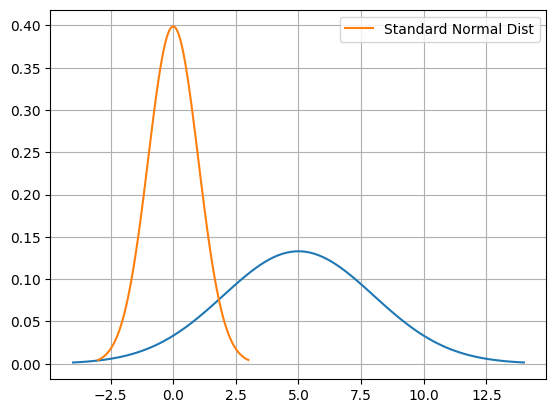

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Define the mean and standard deviation
mu = 5
sigma = 3
mu2 = 0
sigma_2 = 1

# 2. Create the x-axis values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x1 = np.linspace(mu2 - 3*sigma_2, mu2 + 3*sigma_2, 100)

# 3. Calculate the probability density function (PDF)
pdf = norm.pdf(x, mu, sigma)
pdf_2 = norm.pdf(x1,mu2,sigma_2)

# 4. Plot the normal curve
plt.plot(x, pdf)
plt.plot(x1,pdf_2, label='Standard Normal Dist')
plt.legend()
plt.grid(True)
plt.show()